In [1]:
%pylab inline --no-import-all
import matplotlib.ticker as ticker
import matplotlib.cm as cmap
import matplotlib.pyplot as pl

import math
import numpy as np
import scipy.special as ssp
import scipy.stats as ss

from iminuit import Minuit

#Fix root
import sys
sys.path.append("/usr/local/Cellar/root/6.12.04_1/lib/root/")
sys.path.append("/Library/Python/2.7/site-packages/")

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

import george

Populating the interactive namespace from numpy and matplotlib
Welcome to JupyROOT 6.12/04


/usr/local/Cellar/python/2.7.14_3/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py:252: RuntimeWarning: creating converter for unknown type "_Atomic(bool)"
  value = getattr(object, key)


In [2]:
from meanAndKernel import Kernel

In [3]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1.-2.*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

In [4]:
def makePlots(xs, ys, bkg, title, col='g', ymax=1e6):
    f, (ax1, ax2) = pl.subplots(2, sharex=True, figsize=(8,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    ax1.set_xscale("log", nonposx='clip')
    ax1.set_yscale("log", nonposy='clip')
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label='data')
    bkgPlot, = ax1.plot(xs, bkg, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_xlim( 1e3, 9e3 )
    ax1.set_ylim( 1e-1,   ymax  )
    ax1.set_ylabel('events', fontsize=16)
    
    zvals, chi2 = calcSignificance(ys, bkg)
    print "chi2", chi2
    h1 = Hist(binedges,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]
    
    h1.fillcolor = 'green'
    h1.fillstyle = 'solid'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim( 1e3, 9e3 )
    ax2.set_ylim( -5,  5)
    ax2.set_xlabel('m_inv'+ '  [GeV]', fontsize=16)

In [5]:
ycounts = np.load("inputs/ycounts.npy")
yerrs = np.load("inputs/yerrs.npy")

xbins = np.load("inputs/xbins.npy")
xerrs = np.load("inputs/xerrs.npy")
binedges = list(np.load("inputs/binedges.npy"))

# This NEEDS to be fixed, there's a problem of GP convergence
# in the very last points of the spectrum
ycounts = ycounts[:-10]
yerrs = yerrs[:-10]
xbins = xbins[:-10]
xerrs = xerrs[:-10]
binedges = binedges[:-10]

In [6]:
class logLike_minuit:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, lengthscale):
        gp = george.GP(Kernel((Amp, lengthscale)))
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return 0

In [7]:
def fit_gp_minuit(num, lnprob):
    min_likelihood = np.inf
    best_fit_params = (0, 0, 0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 100.
        init1 = np.random.random() * 20.
        init2 = np.random.random() * 1. 
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  Amp = init0, lengthscale = init1, 
                   error_Amp = 1e1, error_lengthscale = 1e1,
                  limit_Amp = (0.01, 1e10), limit_lengthscale = (100, 1e6)) 
        m.migrad()
        if m.fval < min_likelihood:
            min_likelihood = m.fval
            best_fit_params = m.args 
    print "min LL", min_likelihood
    print "best fit vals", best_fit_params
    return min_likelihood, best_fit_params

In [8]:
p_init = [5, 1e3]
Amp, lengthscale = p_init

In [9]:
kernel = Kernel((Amp, lengthscale))
gp = george.GP(kernel)
gp.compute(xbins, yerrs)

In [10]:
lnProb = logLike_minuit(xbins, ycounts, xerrs)
min_likelihood, best_fit_gp = fit_gp_minuit(100, lnProb)
Amp, lengthscale = best_fit_gp

np.save("inputs/fixedHyperparameters.npy",best_fit_gp)

min LL 292.211453469
best fit vals (1367806304.0055063, 828842.0537588805)


In [11]:
Amp, lengthscale = best_fit_gp
kernel = Kernel((Amp, lengthscale))
gp = george.GP(kernel)
gp.compute(xbins, yerrs)

MAP_GP, cov_GP = gp.predict(ycounts, xbins)

chi2 40.921138293456224


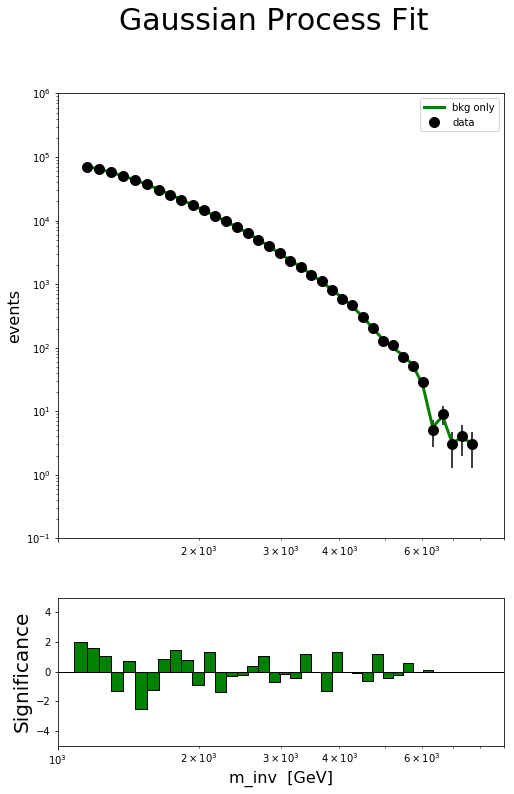

In [12]:
makePlots(xbins, ycounts, MAP_GP, 'Gaussian Process Fit')

In [13]:
def samplesPlot(xs, ys, bkgFits, title, ymax = 1e6):
    f, ax1 = pl.subplots(1, sharex=True, figsize=(8,8))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data")
    for ik, bkg in enumerate(bkgFits):
        if ik == 0:
            bkgPlot, =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0, label="Posterior samples")
        else:
            bkgPlot =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0)
    ax1.legend()
    ax1.set_ylabel('Events')
    ax1.tick_params(axis='y')
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim( 1e3, 9e3 )
    ax1.set_ylim( 1e-1,   ymax  )
    
    #f.subplots_adjust(hspace=0)
    #pl.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    pl.show()

In [14]:
samps = gp.sample_conditional(ycounts, xbins, 1000)

/usr/local/lib/python2.7/site-packages/george-0.3.1-py2.7-macosx-10.13-x86_64.egg/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.


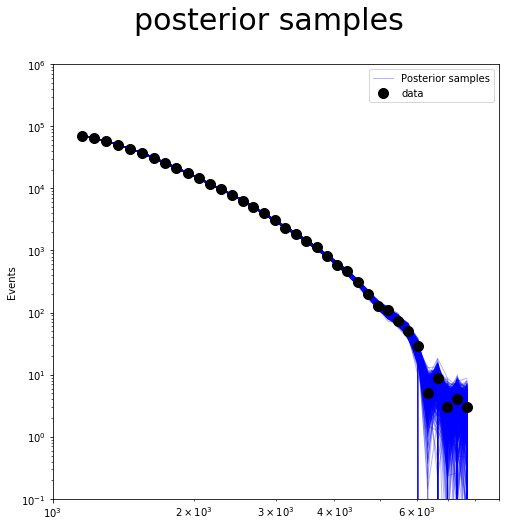

In [15]:
samplesPlot(xbins, ycounts, samps, "posterior samples")

In [16]:
def draw_pulls(pulls):
    pl.figure()
    bins=np.linspace(-4.,4.,50)

    pull_mean = np.mean(pulls)
    pull_std = np.std(pulls)
    

    n, _, _ = pl.hist(pulls, bins=bins, normed=True)
    pl.plot(bins, ss.norm.pdf(bins, pull_mean, pull_std), c='black', linewidth='3', label="N({:.1f}, {:.1f})".format(pull_mean, pull_std))
    pl.plot(bins, ss.norm.pdf(bins, 0,1), c='r', linewidth='3', label="N(0,1)")
    print(pull_mean, pull_std)

    pl.xlabel("(GP-Smeared)/GP Uncertainty", fontsize=20)
    pl.tick_params(axis='y', labelsize=20)
    pl.tick_params(axis='x', labelsize=20)
    pl.legend()

(-0.007904343536282481, 0.9955422681478371)


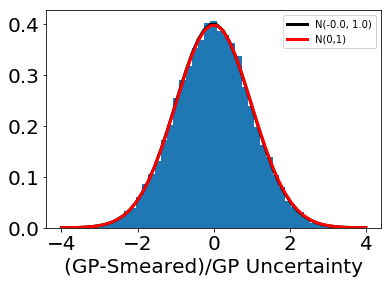

In [18]:
pull=[]
for s in samps:
    pull+=list((s-MAP_GP)/np.sqrt(np.diag(cov_GP)))
draw_pulls(pull)